# **Notebook 05 — Spatial Inference and Probability Mapping**

## Predictive Archaeological Modelling — Peru (v2)
**Author:** Yishar Piero Nieto Barrientos

---

## Objective

Apply the best trained classifier (serialized in Notebook 04) to raster feature
layers and generate a continuous probability surface (0–1) representing
archaeological potential.

## Pipeline

| Step | Description |
|------|-------------|
| 1 | Load serialized model + scaler and validate compatibility |
| 2 | Register input raster paths from `src/config.py` and verify spatial integrity |
| 3 | Define Area of Interest (AOI) via GPS coordinates |
| 4 | Stack features, mask NoData, run `predict_proba` |
| 5 | Export probability surface as GeoTIFF (ESRI:102033) |
| 6 | Feature importance analysis (Mean Decrease in Impurity) |
| 7 | Visual validation against official archaeological records |
| 8 | Probability distribution and cumulative coverage analysis |
| 9 | Quantitative validation: site capture rate (Kvamme gain) |
| 10 | Prediction uncertainty mapping (ensemble disagreement) |

**Depends on:** Notebook 04 (serialized model + scaler).
**Next:** Notebook 06 (Multi-Region Extension).


## 1. Configuration and Model Loading

All paths, feature registry, and constants are imported from `src/config.py`.
The serialized model (best from Notebook 04) must expose `predict_proba` for
continuous probability output.  Features excluded during training (redundancy
removal in NB04: `rugosidad`, `pisos_ecologicos`) are automatically skipped.


In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import time
import glob
import logging

import numpy as np
import joblib
import rasterio
from rasterio.windows import Window
from rasterio.warp import transform as warp_transform

from src.config import (
    RASTER_DIR, MODELS_DIR, RAW_DIR,
    RASTER_REGISTRY, get_feature_names,
    figures_dir, CRS,
)

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# ---------------------------------------------------------------------------
# Paths (derived from config)
# ---------------------------------------------------------------------------
OUTPUT_DIR  = os.path.join(os.path.abspath(".."), "outputs", "predicciones")
FIGURES_DIR = figures_dir("05_prediction")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------------------------------------------------------
# Redundant variables removed in NB04 — must be excluded from prediction
# ---------------------------------------------------------------------------
EXCLUDED_FEATURES = {"rugosidad", "pisos_ecologicos"}

# ---------------------------------------------------------------------------
# Build FEATURE_RASTERS dynamically from config (excluding dropped vars)
# ---------------------------------------------------------------------------
FEATURE_RASTERS = {}
FEATURE_LABELS  = {}

for rv in RASTER_REGISTRY:
    if rv.name in EXCLUDED_FEATURES:
        continue
    FEATURE_RASTERS[rv.name] = rv.path
    FEATURE_LABELS[rv.name]  = f"{rv.label} ({rv.unit})" if rv.unit else rv.label

print(f"Features for prediction ({len(FEATURE_RASTERS)}):")
for name, path in FEATURE_RASTERS.items():
    status = "OK" if os.path.exists(path) else "MISSING"
    print(f"  [{status}] {name:<20s} -> {os.path.basename(path)}")

# ---------------------------------------------------------------------------
# Vector paths for validation
# ---------------------------------------------------------------------------
VECTOR_PATHS = {
    "declarados":  os.path.join(RAW_DIR, "declarados", "declarados.shp"),
    "delimitados": os.path.join(RAW_DIR, "delimitados", "delimitados.shp"),
}

# ---------------------------------------------------------------------------
# AOI center — Cusco, Peru (WGS84)
# ---------------------------------------------------------------------------
AOI_LAT = -13.5167
AOI_LON = -71.9781
WINDOW_HALF_SIZE = 1500  # pixels (~90 x 90 km at 30 m resolution)


Features for prediction (13):
  [OK] pendiente            -> pendiente.tif
  [OK] dist_rios            -> distancia_rios.tif
  [OK] dist_lagos           -> distancia_lagos.tif
  [OK] dist_qhapaq          -> distancia_qhapaq_nan.tif
  [OK] dist_declarados      -> distancia_declarados.tif
  [OK] dist_g1              -> distancia_g1.tif
  [OK] dist_g2              -> distancia_g2.tif
  [OK] dist_g3              -> distancia_g3.tif
  [OK] altitud              -> altitud.tif
  [OK] aspecto              -> aspecto.tif
  [OK] curvatura            -> curvatura.tif
  [OK] tpi                  -> tpi.tif
  [OK] twi                  -> twi.tif


In [2]:
# ---------------------------------------------------------------------------
# Load model + scaler (auto-detect best model from NB04)
# ---------------------------------------------------------------------------
model_files = sorted(glob.glob(os.path.join(MODELS_DIR, "modelo_*_final.pkl")))
assert model_files, f"No serialized models found in {MODELS_DIR}"

MODEL_PATH  = model_files[0]  # best model exported by NB04
SCALER_PATH = os.path.join(MODELS_DIR, "scaler_entrenamiento.pkl")

model = joblib.load(MODEL_PATH)
logger.info("Model loaded: %s  (%s)", os.path.basename(MODEL_PATH), type(model).__name__)

# Load scaler (kept for compatibility — tree models don't need it)
if os.path.exists(SCALER_PATH):
    scaler = joblib.load(SCALER_PATH)
    logger.info("Scaler loaded: %s", SCALER_PATH)
else:
    scaler = None
    logger.warning("No scaler found — assuming tree-based model (no scaling needed).")

assert hasattr(model, "predict_proba"), (
    "Model does not support predict_proba. "
    "A probabilistic classifier is required for continuous mapping."
)

# Verify feature count matches
expected_n = len(FEATURE_RASTERS)
if hasattr(model, "n_features_in_"):
    model_n = model.n_features_in_
    assert model_n == expected_n, (
        f"Feature mismatch: model expects {model_n} features, "
        f"but {expected_n} rasters registered. Check EXCLUDED_FEATURES."
    )
    logger.info("Feature count verified: %d features.", model_n)

logger.info("predict_proba available — continuous probability mapping enabled.")


2026-02-16 16:38:51,416 - INFO - Model loaded: modelo_gradient_boosting_final.pkl  (GradientBoostingClassifier)
2026-02-16 16:38:51,417 - INFO - Scaler loaded: /home/mazapan/Documentos/arqueologia-predictiva/models/scaler_entrenamiento.pkl
2026-02-16 16:38:51,418 - INFO - Feature count verified: 13 features.
2026-02-16 16:38:51,419 - INFO - predict_proba available — continuous probability mapping enabled.


## 2. Input Raster Verification

All feature rasters must exist and share the same CRS, resolution, and extent.
The feature order must match the training order from Notebook 04.


In [3]:
# ---------------------------------------------------------------------------
# Verify raster existence and spatial consistency
# ---------------------------------------------------------------------------
# Note: Rasters may have different geographic extents (e.g., rivers only cover
# certain regions), but must share the same CRS and resolution (30 m grid).
# The inference engine (Section 4) handles partial coverage via NoData masking.

reference_crs = None
reference_res = None

raster_info = {}

for name, path in FEATURE_RASTERS.items():
    assert os.path.exists(path), f"Missing raster: {name} -> {path}"
    with rasterio.open(path) as src:
        raster_info[name] = {
            "shape": src.shape,
            "crs": src.crs,
            "res": src.res,
            "bounds": src.bounds,
            "dtype": src.dtypes[0]
        }
        
        if reference_crs is None:
            reference_crs = src.crs
            reference_res = src.res
        else:
            assert src.crs == reference_crs, f"CRS mismatch in {name}"
            assert np.allclose(src.res, reference_res, atol=0.01), \
                f"Resolution mismatch in {name}: {src.res} vs {reference_res}"
    
    logger.info(
        "OK  %-15s  shape=%s  res=%.1f m  bounds=[%.0f, %.0f, %.0f, %.0f]",
        name, raster_info[name]["shape"], src.res[0],
        src.bounds.left, src.bounds.bottom, src.bounds.right, src.bounds.top
    )

logger.info("CRS: %s | Resolution: %.1f m", reference_crs, reference_res[0])
logger.info("All %d feature rasters verified (CRS & resolution).", len(FEATURE_RASTERS))
logger.info("Note: Rasters may have partial geographic coverage; inference handles NoData.")

2026-02-16 16:39:39,305 - INFO - OK  pendiente        shape=(75591, 53579)  res=30.0 m  bounds=[-2510197, 1354665, -902827, 3622395]
2026-02-16 16:39:39,350 - INFO - OK  dist_rios        shape=(73649, 54008)  res=30.0 m  bounds=[-2451928, 1417349, -831685, 3626820]
2026-02-16 16:39:39,393 - INFO - OK  dist_lagos       shape=(73649, 54008)  res=30.0 m  bounds=[-2451928, 1417349, -831685, 3626820]
2026-02-16 16:39:39,425 - INFO - OK  dist_qhapaq      shape=(56929, 45799)  res=30.0 m  bounds=[-2291766, 1518071, -917796, 3225927]
2026-02-16 16:39:39,444 - INFO - OK  dist_declarados  shape=(70615, 51098)  res=30.0 m  bounds=[-2422875, 1464900, -889929, 3583343]
2026-02-16 16:39:39,458 - INFO - OK  dist_g1          shape=(73649, 54008)  res=30.0 m  bounds=[-2451928, 1417349, -831685, 3626820]
2026-02-16 16:39:39,475 - INFO - OK  dist_g2          shape=(73649, 54008)  res=30.0 m  bounds=[-2451928, 1417349, -831685, 3626820]
2026-02-16 16:39:39,495 - INFO - OK  dist_g3          shape=(73649, 5

## 3. Area of Interest - Window Definition

The AOI is defined by a GPS coordinate (WGS84) which is reprojected to the
native CRS (ESRI:102033). A square window of `WINDOW_HALF_SIZE * 2` pixels
is created around the center pixel.

At 30 m resolution, 3000 px = 90 km per side.

In [4]:
# ---------------------------------------------------------------------------
# Reproject AOI center and build rasterio Window
# ---------------------------------------------------------------------------
ref_path = FEATURE_RASTERS["pendiente"]

with rasterio.open(ref_path) as src:
    xs, ys = warp_transform("EPSG:4326", src.crs, [AOI_LON], [AOI_LAT])
    x_center, y_center = xs[0], ys[0]
    row_center, col_center = src.index(x_center, y_center)

    col_off = max(0, col_center - WINDOW_HALF_SIZE)
    row_off = max(0, row_center - WINDOW_HALF_SIZE)
    win_size = WINDOW_HALF_SIZE * 2

    aoi_window = Window(
        col_off=col_off,
        row_off=row_off,
        width=win_size,
        height=win_size
    )
    aoi_transform = src.window_transform(aoi_window)
    project_crs = src.crs

logger.info(
    "AOI center: (%.4f, %.4f) -> pixel (%d, %d)",
    AOI_LAT, AOI_LON, row_center, col_center
)
logger.info("Window: %d x %d px | offset: (%d, %d)", win_size, win_size, col_off, row_off)

2026-02-16 16:39:45,952 - INFO - AOI center: (-13.5167, -71.9781) -> pixel (50808, 41971)
2026-02-16 16:39:45,954 - INFO - Window: 3000 x 3000 px | offset: (40471, 49308)


## 4. Spatial Inference

**Steps:**
1. Read each feature raster within the AOI window and stack into a 3-D array `(n_features, height, width)`.
2. Reshape to `(n_pixels, n_features)` for scikit-learn compatibility.
3. Build a NoData mask: pixels with `NaN` in any layer are excluded.
4. Call `model.predict_proba()` on valid pixels and collect class-1 probability.
5. Reshape back to 2-D for export.

In [5]:
# ---------------------------------------------------------------------------
# Stack features and predict
# ---------------------------------------------------------------------------
t0 = time.time()

layers = []
for name, path in FEATURE_RASTERS.items():
    with rasterio.open(path) as src:
        layers.append(src.read(1, window=aoi_window))

stack = np.stack(layers, axis=0)  # (n_features, H, W)
n_features, height, width = stack.shape
logger.info("Stack shape: %s", stack.shape)

# Flatten to (n_pixels, n_features)
X = stack.transpose(1, 2, 0).reshape(-1, n_features)

# NoData mask
valid_mask = ~np.isnan(X).any(axis=1)
n_valid = valid_mask.sum()
logger.info("Valid pixels: %s / %s (%.1f%%)", f"{n_valid:,}", f"{X.shape[0]:,}", 100 * n_valid / X.shape[0])

# Predict
prob_flat = np.full(X.shape[0], np.nan, dtype=np.float32)
if n_valid > 0:
    prob_flat[valid_mask] = model.predict_proba(X[valid_mask])[:, 1]
else:
    logger.warning("No valid pixels in AOI. Check coordinates.")

probability_map = prob_flat.reshape(height, width)

elapsed = time.time() - t0
logger.info("Inference completed in %.1f s", elapsed)

2026-02-16 16:40:09,026 - INFO - Stack shape: (13, 3000, 3000)
2026-02-16 16:40:09,128 - INFO - Valid pixels: 9,000,000 / 9,000,000 (100.0%)
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
2026-02-16 16:40:20,435 - INFO - Inference completed in 28.8 s


## 5. Export GeoTIFF

The probability surface is saved as a single-band `Float32` GeoTIFF with:
- CRS inherited from the project (ESRI:102033).
- Affine transform computed for the AOI window.
- LZW compression to reduce file size.
- `NaN` as NoData value for transparency in GIS viewers.

In [6]:
# ---------------------------------------------------------------------------
# Write GeoTIFF
# ---------------------------------------------------------------------------
output_filename = "mapa_calor_cusco_ampliado.tif"
output_path = os.path.join(OUTPUT_DIR, output_filename)

with rasterio.open(ref_path) as src:
    profile = src.profile.copy()

profile.update(
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype="float32",
    crs=project_crs,
    transform=aoi_transform,
    nodata=np.nan,
    compress="lzw"
)

with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(probability_map.astype(np.float32), 1)

logger.info("GeoTIFF saved: %s", output_path)
logger.info("CRS: %s | Size: %d x %d", project_crs, width, height)

2026-02-16 16:41:02,366 - INFO - GeoTIFF saved: /home/mazapan/Documentos/arqueologia-predictiva/outputs/predicciones/mapa_calor_cusco_ampliado.tif
2026-02-16 16:41:02,366 - INFO - CRS: ESRI:102033 | Size: 3000 x 3000


## 6. Feature Importance

If the best model exposes `feature_importances_` (tree-based models: Random Forest,
Gradient Boosting, XGBoost), the Mean Decrease in Impurity (MDI) ranking is shown.
This indicates the relative contribution of each variable to the classification.


2026-02-16 16:43:44,659 - INFO - Feature importance figure saved: /home/mazapan/Documentos/arqueologia-predictiva/outputs/figures/05_prediction/feature_importance.png


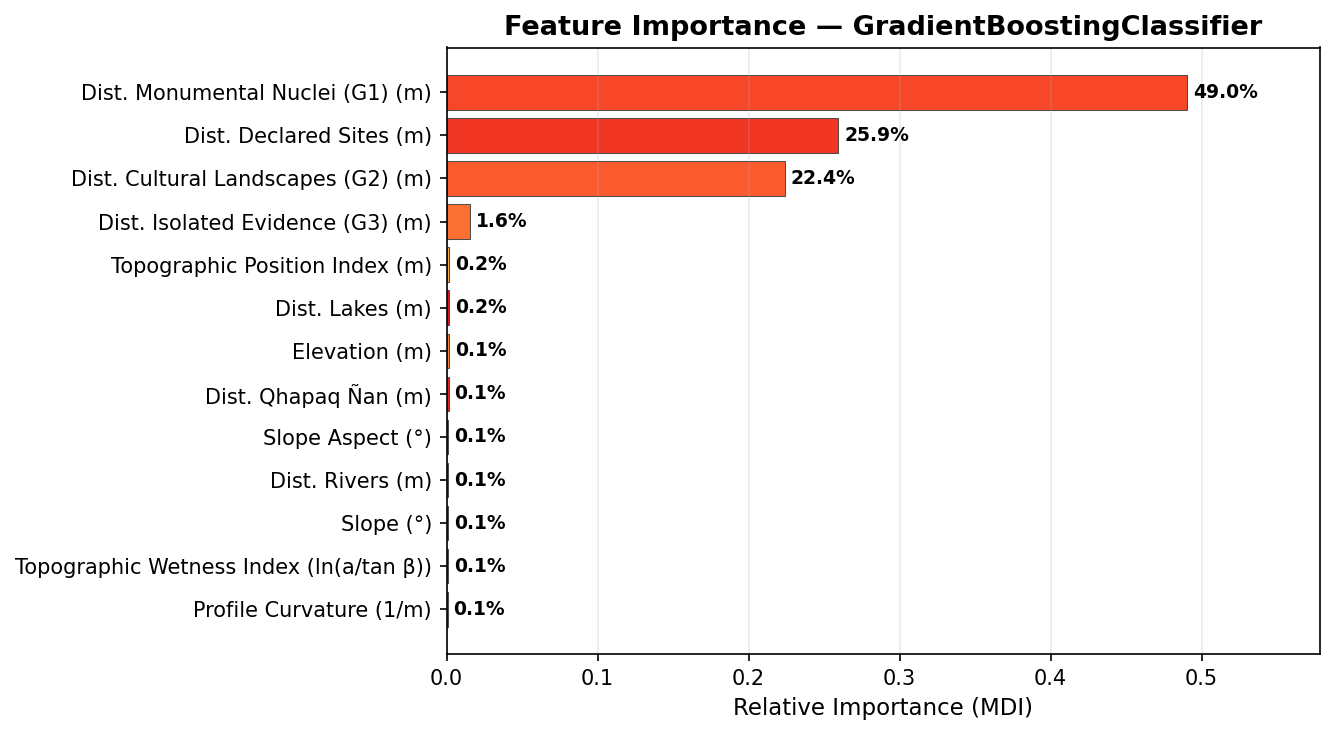


Feature                               Weight
---------------------------------------------
Dist. Monumental Nuclei (G1) (m)      49.0%
Dist. Declared Sites (m)              25.9%
Dist. Cultural Landscapes (G2) (m)    22.4%
Dist. Isolated Evidence (G3) (m)       1.6%
Topographic Position Index (m)         0.2%
Dist. Lakes (m)                        0.2%
Elevation (m)                          0.1%
Dist. Qhapaq Ñan (m)                   0.1%
Slope Aspect (°)                       0.1%
Dist. Rivers (m)                       0.1%
Slope (°)                              0.1%
Topographic Wetness Index (ln(a/tan β))    0.1%
Profile Curvature (1/m)                0.1%


In [11]:
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Feature importance bar chart
# ---------------------------------------------------------------------------
feature_names = list(FEATURE_RASTERS.keys())

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    labels = [FEATURE_LABELS.get(f, f) for f in feature_names]

    # Sort descending
    order = np.argsort(importances)[::-1]
    imp_sorted = importances[order]
    lbl_sorted = [labels[i] for i in order]

    fig, ax = plt.subplots(figsize=(9, 5), dpi=150)
    colors = plt.cm.YlOrRd(np.linspace(0.35, 0.85, len(imp_sorted)))[::-1]

    bars = ax.barh(
        range(len(imp_sorted)), imp_sorted,
        color=colors[order], edgecolor="0.3", linewidth=0.5
    )
    ax.set_yticks(range(len(lbl_sorted)))
    ax.set_yticklabels(lbl_sorted, fontsize=10)
    ax.invert_yaxis()
    ax.set_xlabel("Relative Importance (MDI)", fontsize=11)
    ax.set_title(
        f"Feature Importance — {type(model).__name__}",
        fontsize=13, fontweight="bold",
    )

    for i, val in enumerate(imp_sorted):
        ax.text(val + 0.004, i, f"{val:.1%}", va="center", fontsize=9, fontweight="bold")

    ax.set_xlim(0, imp_sorted.max() * 1.18)
    ax.grid(axis="x", alpha=0.25)
    plt.tight_layout()

    fig_path = os.path.join(FIGURES_DIR, "feature_importance.png")
    fig.savefig(fig_path, dpi=200, bbox_inches="tight")
    logger.info("Feature importance figure saved: %s", fig_path)
    plt.show()

    # Summary table
    print()
    print("{:<35s} {:>8s}".format("Feature", "Weight"))
    print("-" * 45)
    for lbl, val in zip(lbl_sorted, imp_sorted):
        print(f"{lbl:<35s} {val:>7.1%}")
else:
    print(f"Model ({type(model).__name__}) does not expose feature_importances_.")


## 7. Visual Validation

Three-panel figure comparing the model output against official records:

| Panel | Content |
|-------|---------|
| A | Raw probability surface |
| B | Overlay with declared sites (points) and delimited zones (polygons) |
| C | High-probability mask (>= 0.7) vs. known sites |

All layers remain in **ESRI:102033** to avoid reprojection artifacts.  
Vectors are clipped to the raster extent before plotting.

In [8]:
import geopandas as gpd
from rasterio.plot import show
from shapely.geometry import box
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe


def clip_vectors_to_raster(raster_path, vector_paths):
    """Load and clip vector layers to the extent of a raster, in native CRS."""
    with rasterio.open(raster_path) as src:
        crs = src.crs
        b = src.bounds

    bbox = gpd.GeoDataFrame({"geometry": [box(b.left, b.bottom, b.right, b.top)]}, crs=crs)
    result = {}
    for key, path in vector_paths.items():
        gdf = gpd.read_file(path)
        if gdf.crs != crs:
            gdf = gdf.to_crs(crs)
        result[key] = gpd.clip(gdf, bbox)
        logger.info("%s: %d features within AOI", key, len(result[key]))
    return result


# Load data
vectors = clip_vectors_to_raster(output_path, VECTOR_PATHS)
gdf_pts = vectors["declarados"]
gdf_pol = vectors["delimitados"]

src_raster = rasterio.open(output_path)
raster_data = src_raster.read(1)
extent = [src_raster.bounds.left, src_raster.bounds.right,
          src_raster.bounds.bottom, src_raster.bounds.top]

2026-02-16 16:41:28,499 - INFO - declarados: 5 features within AOI
2026-02-16 16:41:28,941 - INFO - delimitados: 314 features within AOI


2026-02-16 16:41:49,723 - INFO - Validation figure saved: /home/mazapan/Documentos/arqueologia-predictiva/outputs/figures/05_prediction/validation_cusco_3panel.png


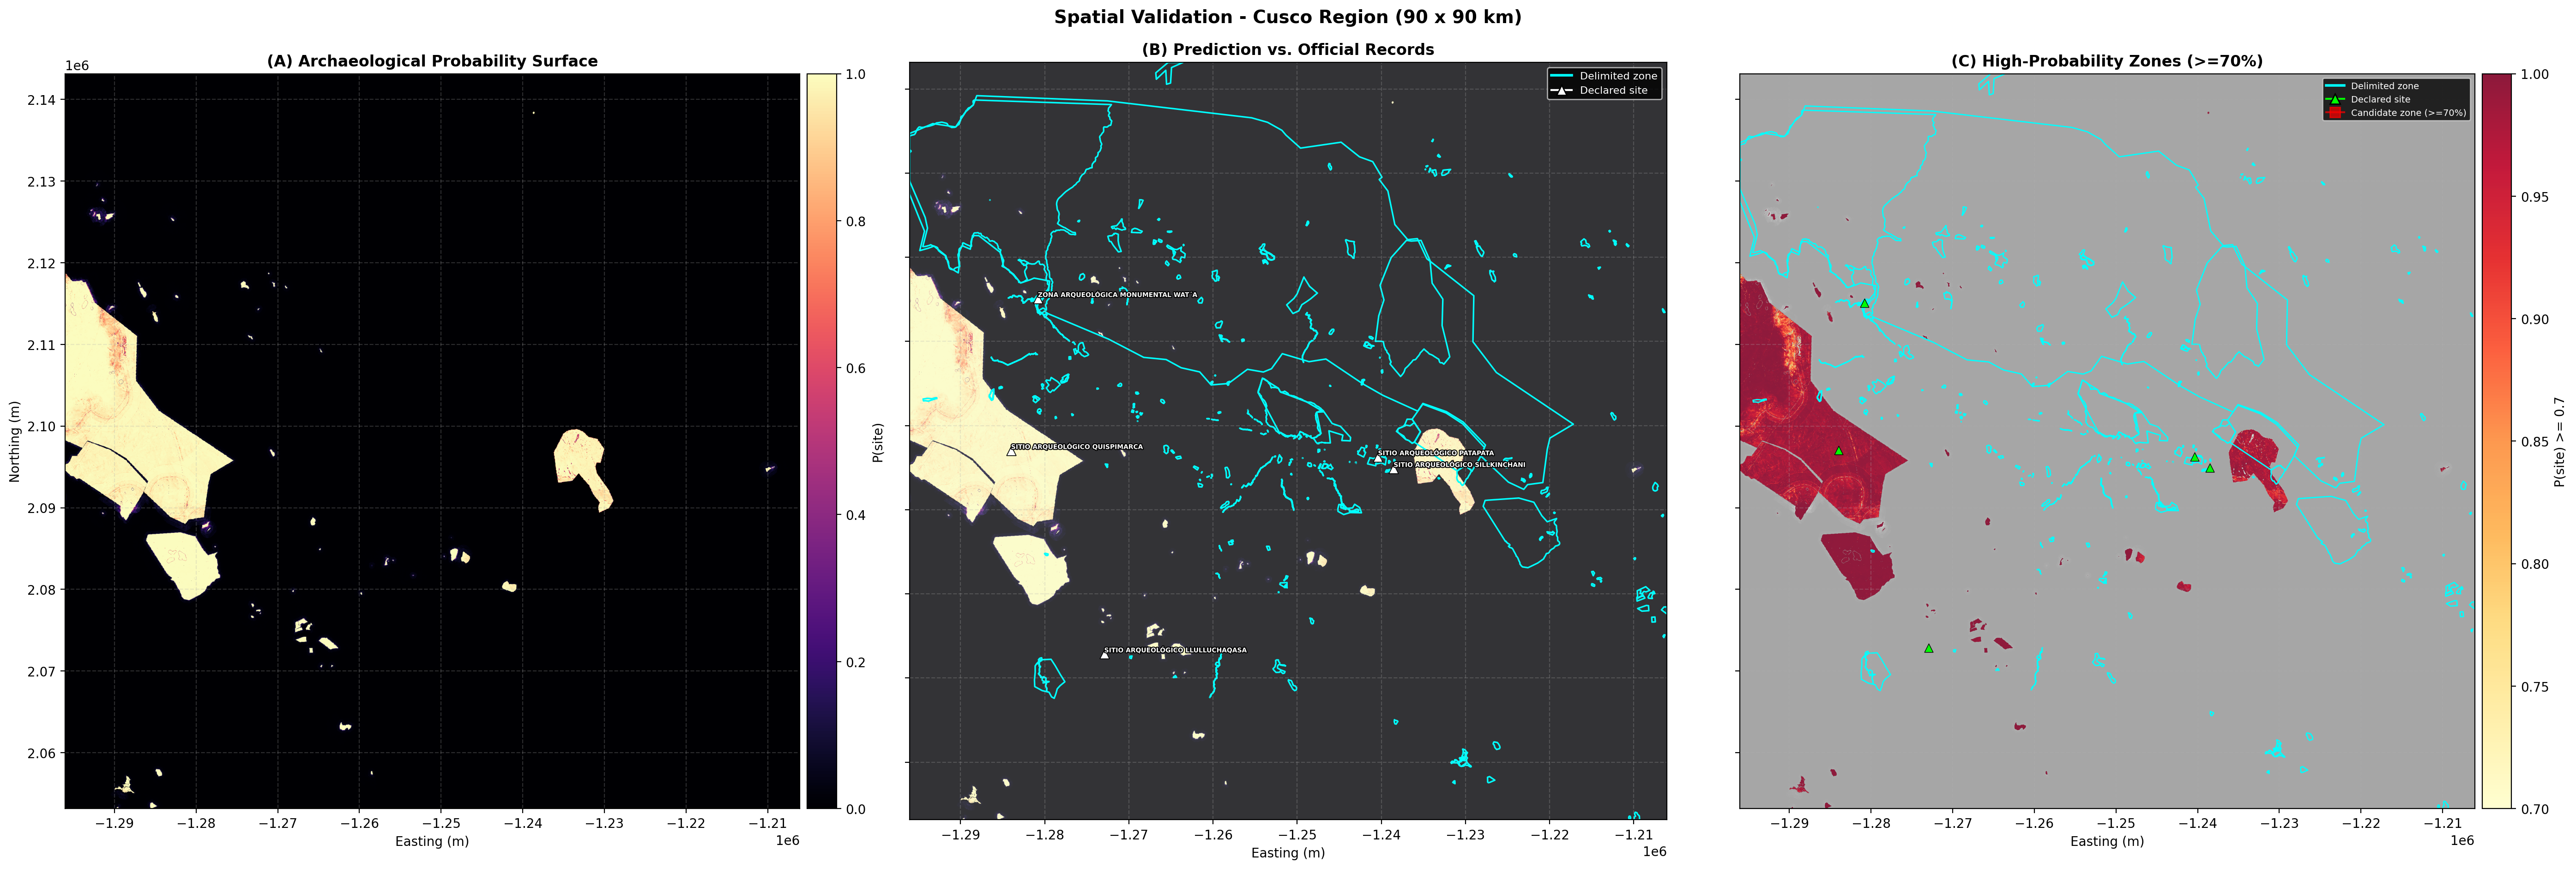

In [9]:
# ---------------------------------------------------------------------------
# Three-panel validation figure
# ---------------------------------------------------------------------------
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(28, 9), dpi=200)

# --- Panel A: Raw probability surface ---
im1 = show(src_raster, ax=ax1, cmap="magma", vmin=0, vmax=1)
ax1.set_title("(A) Archaeological Probability Surface", fontsize=12, fontweight="bold")
ax1.set_xlabel("Easting (m)")
ax1.set_ylabel("Northing (m)")
ax1.grid(True, ls="--", alpha=0.25)

div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="4%", pad=0.08)
plt.colorbar(im1.get_images()[0], cax=cax1, label="P(site)")

# --- Panel B: Overlay with official records ---
show(src_raster, ax=ax2, cmap="magma", vmin=0, vmax=1, alpha=0.8)
gdf_pol.plot(ax=ax2, facecolor="none", edgecolor="#00FFFF", linewidth=1.2)
gdf_pts.plot(ax=ax2, color="white", marker="^", markersize=55, edgecolor="black", linewidth=0.6)

if len(gdf_pts) <= 50 and "nombre_map" in gdf_pts.columns:
    for _, row in gdf_pts.iterrows():
        ax2.text(
            row.geometry.x, row.geometry.y + 200,
            str(row["nombre_map"]), fontsize=5, color="white", weight="bold",
            path_effects=[pe.withStroke(linewidth=1.5, foreground="black")]
        )

ax2.set_title("(B) Prediction vs. Official Records", fontsize=12, fontweight="bold")
ax2.set_xlabel("Easting (m)")
ax2.set_yticklabels([])
ax2.grid(True, ls="--", alpha=0.25)

legend_b = [
    Line2D([0], [0], color="#00FFFF", lw=2, label="Delimited zone"),
    Line2D([0], [0], marker="^", color="w", markeredgecolor="k", label="Declared site", markersize=8)
]
ax2.legend(handles=legend_b, loc="upper right", frameon=True, facecolor="black", labelcolor="white", fontsize=8)

# --- Panel C: High-probability mask (>= 0.7) ---
show(src_raster, ax=ax3, cmap="Greys_r", vmin=0, vmax=1, alpha=0.35)

high_prob = np.where(raster_data >= 0.7, raster_data, np.nan)
im3 = ax3.imshow(high_prob, cmap="YlOrRd", vmin=0.7, vmax=1.0,
                  extent=extent, origin="upper", alpha=0.9)

gdf_pol.plot(ax=ax3, facecolor="none", edgecolor="#00FFFF", linewidth=1.0)
gdf_pts.plot(ax=ax3, color="lime", marker="^", markersize=45, edgecolor="black", linewidth=0.5)

ax3.set_title("(C) High-Probability Zones (>=70%)", fontsize=12, fontweight="bold")
ax3.set_xlabel("Easting (m)")
ax3.set_yticklabels([])
ax3.grid(True, ls="--", alpha=0.25)

div3 = make_axes_locatable(ax3)
cax3 = div3.append_axes("right", size="4%", pad=0.08)
plt.colorbar(im3, cax=cax3, label="P(site) >= 0.7")

legend_c = [
    Line2D([0], [0], color="#00FFFF", lw=2, label="Delimited zone"),
    Line2D([0], [0], marker="^", color="lime", markeredgecolor="k", label="Declared site", markersize=8),
    Line2D([0], [0], marker="s", color="red", alpha=0.7, label="Candidate zone (>=70%)", markersize=8)
]
ax3.legend(handles=legend_c, loc="upper right", frameon=True, facecolor="black", labelcolor="white", fontsize=7)

fig.suptitle(
    f"Spatial Validation - Cusco Region ({win_size*30/1000:.0f} x {win_size*30/1000:.0f} km)",
    fontsize=14, fontweight="bold", y=1.01
)
plt.tight_layout()

fig_val_path = os.path.join(FIGURES_DIR, "validation_cusco_3panel.png")
fig.savefig(fig_val_path, dpi=200, bbox_inches="tight")
logger.info("Validation figure saved: %s", fig_val_path)
plt.show()

src_raster.close()

## 8. Probability Distribution Analysis

Characterizing the predicted probability surface is essential for threshold
selection and model calibration assessment. A bimodal distribution indicates
strong discrimination between classes; a unimodal one suggests weak separation.

The cumulative coverage curve quantifies the trade-off between threshold
stringency and spatial coverage, directly informing field survey prioritization.

2026-02-16 16:43:07,888 - INFO - Distribution figure saved: /home/mazapan/Documentos/arqueologia-predictiva/outputs/figures/05_prediction/probability_distribution.png


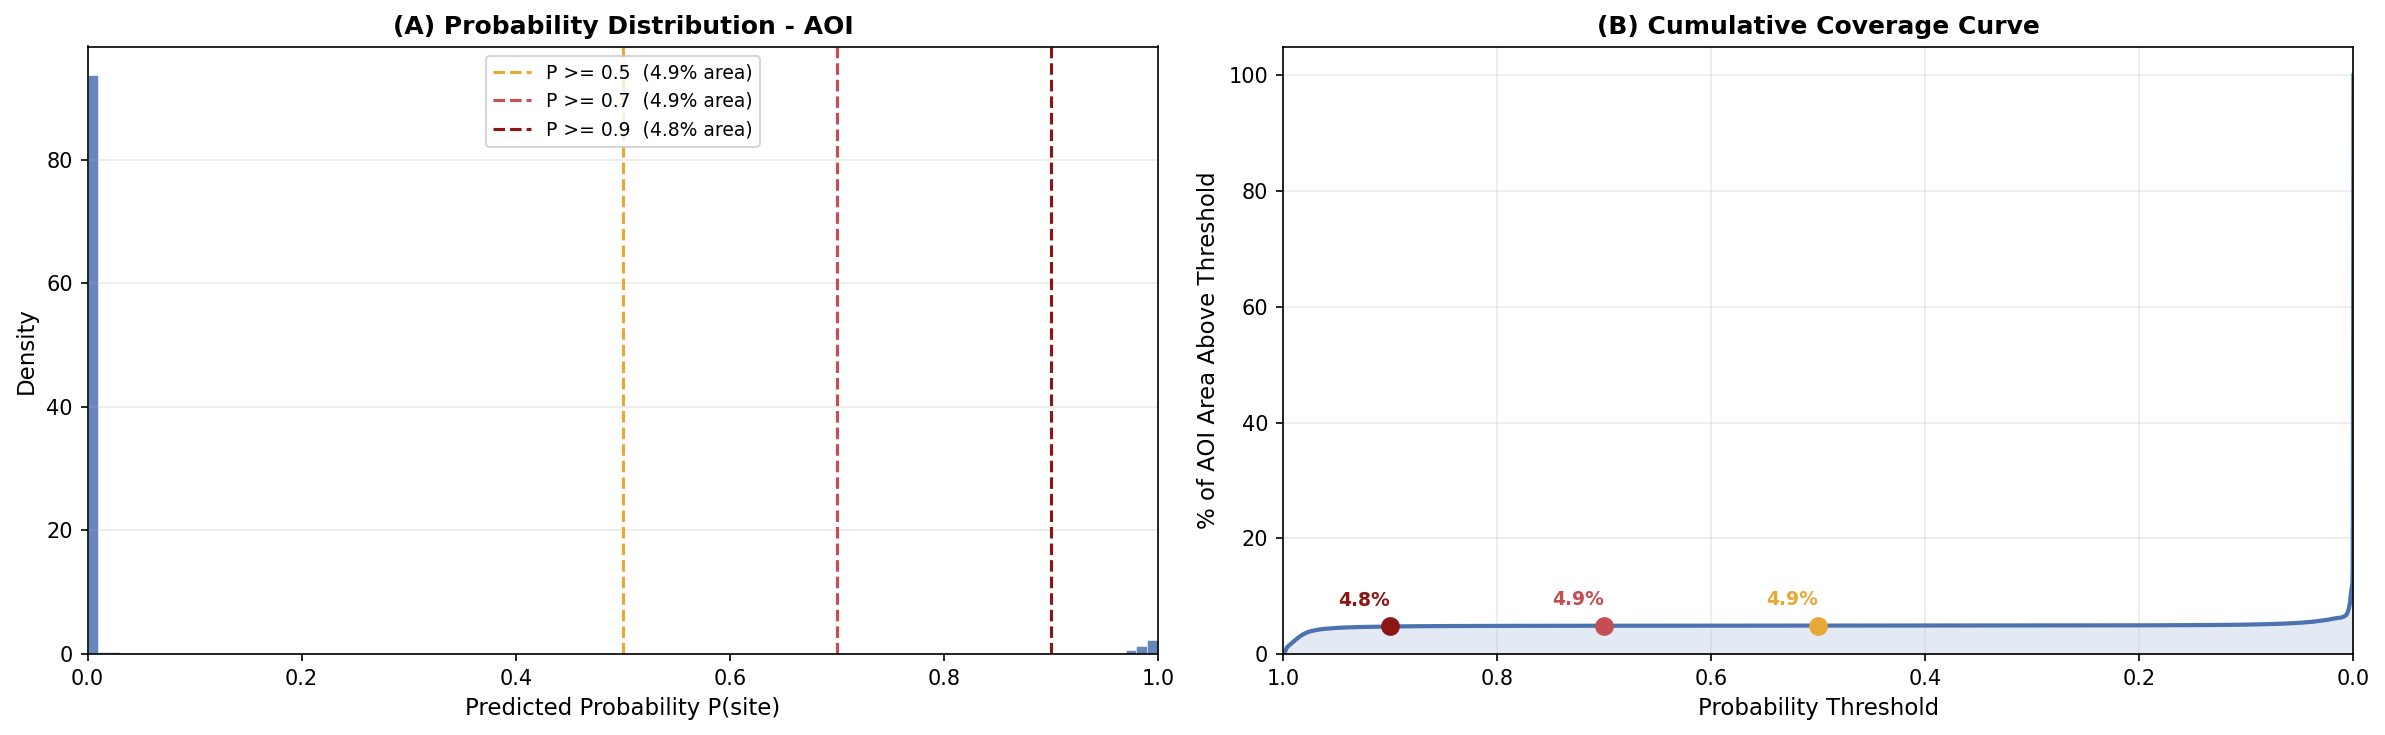


Probability Surface - Summary Statistics
  Valid pixels            9,000,000
  Min                        0.0000
  Q1 (25%)                   0.0003
  Median                     0.0004
  Mean                       0.0495
  Q3 (75%)                   0.0005
  Max                        0.9998
  Std Dev                    0.2119


In [10]:
# ---------------------------------------------------------------------------
# Probability distribution histogram + cumulative coverage curve
# ---------------------------------------------------------------------------
valid_probs = probability_map[~np.isnan(probability_map)].ravel()

fig, (ax_h, ax_c) = plt.subplots(1, 2, figsize=(16, 5), dpi=150)

# --- Left: Histogram ---
ax_h.hist(valid_probs, bins=100, color="#4C72B0", edgecolor="white",
          linewidth=0.3, density=True, alpha=0.85)

thresholds = [0.5, 0.7, 0.9]
th_colors = ["#E8A838", "#C44E52", "#8C1515"]
for th, c in zip(thresholds, th_colors):
    pct_above = 100 * (valid_probs >= th).sum() / len(valid_probs)
    ax_h.axvline(th, color=c, ls="--", lw=1.5,
                 label=f"P >= {th:.1f}  ({pct_above:.1f}% area)")

ax_h.set_xlabel("Predicted Probability P(site)", fontsize=11)
ax_h.set_ylabel("Density", fontsize=11)
ax_h.set_title("(A) Probability Distribution - AOI", fontsize=12, fontweight="bold")
ax_h.legend(fontsize=9, loc="upper center")
ax_h.set_xlim(0, 1)
ax_h.grid(axis="y", alpha=0.25)

# --- Right: Cumulative coverage curve ---
sorted_p = np.sort(valid_probs)[::-1]
cumulative = np.arange(1, len(sorted_p) + 1) / len(sorted_p) * 100

ax_c.plot(sorted_p, cumulative, color="#4C72B0", lw=2)
ax_c.fill_between(sorted_p, cumulative, alpha=0.15, color="#4C72B0")

for th, c in zip(thresholds, th_colors):
    pct = 100 * (valid_probs >= th).sum() / len(valid_probs)
    ax_c.plot(th, pct, "o", color=c, ms=8, zorder=5)
    ax_c.annotate(f"{pct:.1f}%", (th, pct), textcoords="offset points",
                  xytext=(-25, 10), fontsize=9, fontweight="bold", color=c)

ax_c.set_xlabel("Probability Threshold", fontsize=11)
ax_c.set_ylabel("% of AOI Area Above Threshold", fontsize=11)
ax_c.set_title("(B) Cumulative Coverage Curve", fontsize=12, fontweight="bold")
ax_c.set_xlim(0, 1)
ax_c.set_ylim(0, 105)
ax_c.invert_xaxis()
ax_c.grid(alpha=0.25)

plt.tight_layout()
fig_dist_path = os.path.join(FIGURES_DIR, "probability_distribution.png")
fig.savefig(fig_dist_path, dpi=200, bbox_inches="tight")
logger.info("Distribution figure saved: %s", fig_dist_path)
plt.show()

# --- Summary statistics ---
print()
print("Probability Surface - Summary Statistics")
print("=" * 45)
stats = {
    "Valid pixels":  f"{len(valid_probs):,}",
    "Min":           f"{np.min(valid_probs):.4f}",
    "Q1 (25%)":      f"{np.percentile(valid_probs, 25):.4f}",
    "Median":        f"{np.median(valid_probs):.4f}",
    "Mean":          f"{np.mean(valid_probs):.4f}",
    "Q3 (75%)":      f"{np.percentile(valid_probs, 75):.4f}",
    "Max":           f"{np.max(valid_probs):.4f}",
    "Std Dev":       f"{np.std(valid_probs):.4f}",
}
for k, v in stats.items():
    print(f"  {k:<20s} {v:>12s}")

## 9. Quantitative Validation - Site Capture Rate

The **capture rate** (or site hit rate) measures the percentage of known
archaeological sites that fall within zones predicted as high-probability.
This is the spatial equivalent of sensitivity/recall and is the standard
validation metric in predictive archaeological modeling (Kvamme, 1988;
Verhagen & Whitley, 2012).

A well-calibrated model should capture a high proportion of known sites
while flagging a small fraction of the total area, demonstrating that the
model concentrates risk better than random chance.

2026-02-16 16:43:56,609 - INFO - Sites with valid probability: 5 / 5
2026-02-16 16:43:57,127 - INFO - Capture rate figure saved: /home/mazapan/Documentos/arqueologia-predictiva/outputs/figures/05_prediction/capture_rate_analysis.png


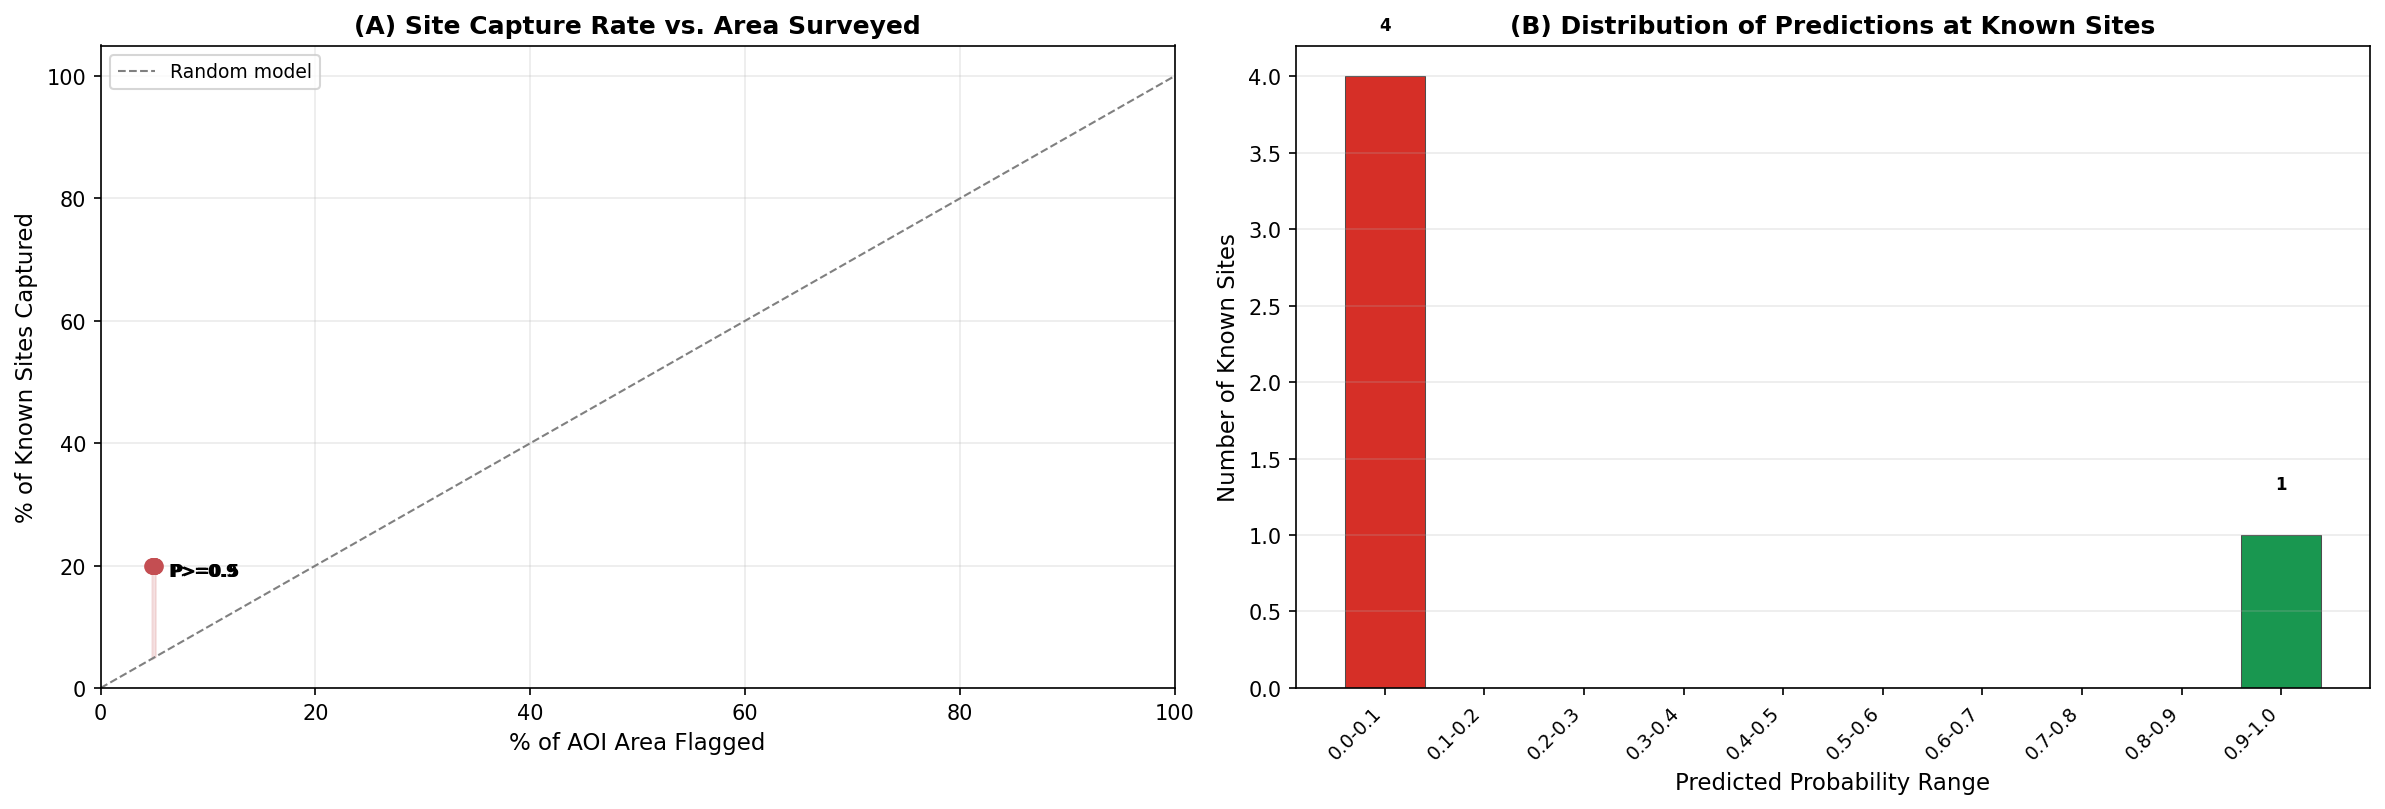


  Threshold     Captured     Rate     Area   Kvamme
-------------------------------------------------------
        0.1     1/5        20.0%     5.1%    3.92
        0.2     1/5        20.0%     5.0%    4.02
        0.3     1/5        20.0%     5.0%    4.04
        0.4     1/5        20.0%     4.9%    4.05
        0.5     1/5        20.0%     4.9%    4.05
        0.6     1/5        20.0%     4.9%    4.06
        0.7     1/5        20.0%     4.9%    4.08
        0.8     1/5        20.0%     4.9%    4.10
        0.9     1/5        20.0%     4.8%    4.20

Kvamme Gain > 1.0 = better than random. Gain >> 1.0 = strong discrimination.


In [12]:
# ---------------------------------------------------------------------------
# Quantitative validation: site capture rate at multiple thresholds
# ---------------------------------------------------------------------------

# Sample probability at each declared site location
with rasterio.open(output_path) as src:
    site_coords = list(zip(gdf_pts.geometry.x, gdf_pts.geometry.y))
    site_probs = np.array([v[0] for v in src.sample(site_coords)])

# Remove NaN (sites outside raster coverage)
valid_site_mask = ~np.isnan(site_probs)
site_probs_valid = site_probs[valid_site_mask]
n_sites = len(site_probs_valid)
logger.info("Sites with valid probability: %d / %d", n_sites, len(site_probs))

# Compute capture rate at multiple thresholds
eval_thresholds = np.arange(0.1, 1.0, 0.1)
capture_data = []

for th in eval_thresholds:
    n_captured = (site_probs_valid >= th).sum()
    capture_rate = 100 * n_captured / n_sites if n_sites > 0 else 0
    area_pct = 100 * (valid_probs >= th).sum() / len(valid_probs)
    gain = capture_rate / area_pct if area_pct > 0 else 0
    capture_data.append((th, n_captured, n_sites, capture_rate, area_pct, gain))

# --- Plot: Capture rate vs Area curve (Kvamme-style) ---
fig, (ax_cap, ax_bar) = plt.subplots(1, 2, figsize=(16, 5.5), dpi=150)

# Left panel: Capture vs Area curve
rates = [100 * (site_probs_valid >= th).sum() / n_sites for th in eval_thresholds]
areas = [100 * (valid_probs >= th).sum() / len(valid_probs) for th in eval_thresholds]

ax_cap.plot(areas, rates, "o-", color="#C44E52", lw=2, ms=7, zorder=3)
ax_cap.plot([0, 100], [0, 100], "--", color="gray", lw=1, label="Random model")
ax_cap.fill_between(areas, rates, [a for a in areas], alpha=0.15, color="#C44E52")

for th, r, a in zip(eval_thresholds, rates, areas):
    if th in [0.5, 0.7, 0.9]:
        ax_cap.annotate(f"P>={th:.1f}", (a, r), textcoords="offset points",
                        xytext=(8, -5), fontsize=8, fontweight="bold")

ax_cap.set_xlabel("% of AOI Area Flagged", fontsize=11)
ax_cap.set_ylabel("% of Known Sites Captured", fontsize=11)
ax_cap.set_title("(A) Site Capture Rate vs. Area Surveyed", fontsize=12, fontweight="bold")
ax_cap.legend(fontsize=9)
ax_cap.set_xlim(0, 100)
ax_cap.set_ylim(0, 105)
ax_cap.grid(alpha=0.25)

# Right panel: Bar chart of site probability distribution
bins_edges = np.arange(0, 1.1, 0.1)
counts, _ = np.histogram(site_probs_valid, bins=bins_edges)
bin_labels = [f"{bins_edges[i]:.1f}-{bins_edges[i+1]:.1f}" for i in range(len(counts))]

colors_bar = plt.cm.RdYlGn(np.linspace(0.1, 0.9, len(counts)))
ax_bar.bar(range(len(counts)), counts, color=colors_bar, edgecolor="0.3", linewidth=0.5)
ax_bar.set_xticks(range(len(bin_labels)))
ax_bar.set_xticklabels(bin_labels, rotation=45, ha="right", fontsize=9)
ax_bar.set_xlabel("Predicted Probability Range", fontsize=11)
ax_bar.set_ylabel("Number of Known Sites", fontsize=11)
ax_bar.set_title("(B) Distribution of Predictions at Known Sites", fontsize=12, fontweight="bold")
ax_bar.grid(axis="y", alpha=0.25)

for i, v in enumerate(counts):
    if v > 0:
        ax_bar.text(i, v + 0.3, str(v), ha="center", fontsize=8, fontweight="bold")

plt.tight_layout()
fig_cap_path = os.path.join(FIGURES_DIR, "capture_rate_analysis.png")
fig.savefig(fig_cap_path, dpi=200, bbox_inches="tight")
logger.info("Capture rate figure saved: %s", fig_cap_path)
plt.show()

# --- Print capture rate table ---
print()
header = f"  {"Threshold":>9s} {"Captured":>12s} {"Rate":>8s} {"Area":>8s} {"Kvamme":>8s}"
print(header)
print("-" * 55)
for th, nc, ns, cr, ap, g in capture_data:
    print(f"  {th:>9.1f} {nc:>5d}/{ns:<5d} {cr:>7.1f}% {ap:>7.1f}% {g:>7.2f}")
print()
print("Kvamme Gain > 1.0 = better than random. Gain >> 1.0 = strong discrimination.")

## 10. Prediction Uncertainty (Ensemble Disagreement) — Sampled Approach

For ensemble models that expose individual estimators, the **standard deviation**
across member predictions quantifies prediction uncertainty: low values indicate
consensus, high values flag ambiguous zones.

- **Random Forest:** Each tree votes independently → `std(tree_proba)`.
- **Gradient Boosting / XGBoost:** Uses staged predictions at different boosting
  rounds to approximate ensemble disagreement.

**Optimization:** Uncertainty is computed on a random sample of valid pixels,
then smoothed via Gaussian filtering to reconstruct the full spatial pattern.


2026-02-16 16:44:14,972 - INFO - Sampling 750000 / 9000000 valid pixels (8.3%) for uncertainty estimation
/home/mazapan/Documentos/arqueologia-predictiva/venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
2026-02-16 16:44:22,870 - INFO - Uncertainty method: GBM staged disagreement (50 stages sampled)
2026-02-16 16:44:22,898 - INFO - Uncertainty computed on sample in 9.1 s
2026-02-16 16:44:23,300 - INFO - Uncertainty smoothed and mapped in 9.5 s
2026-02-16 16:44:31,618 - INFO - Uncertainty figure saved: /home/mazapan/Documentos/arqueologia-predictiva/outputs/figures/05_prediction/prediction_uncertainty.png


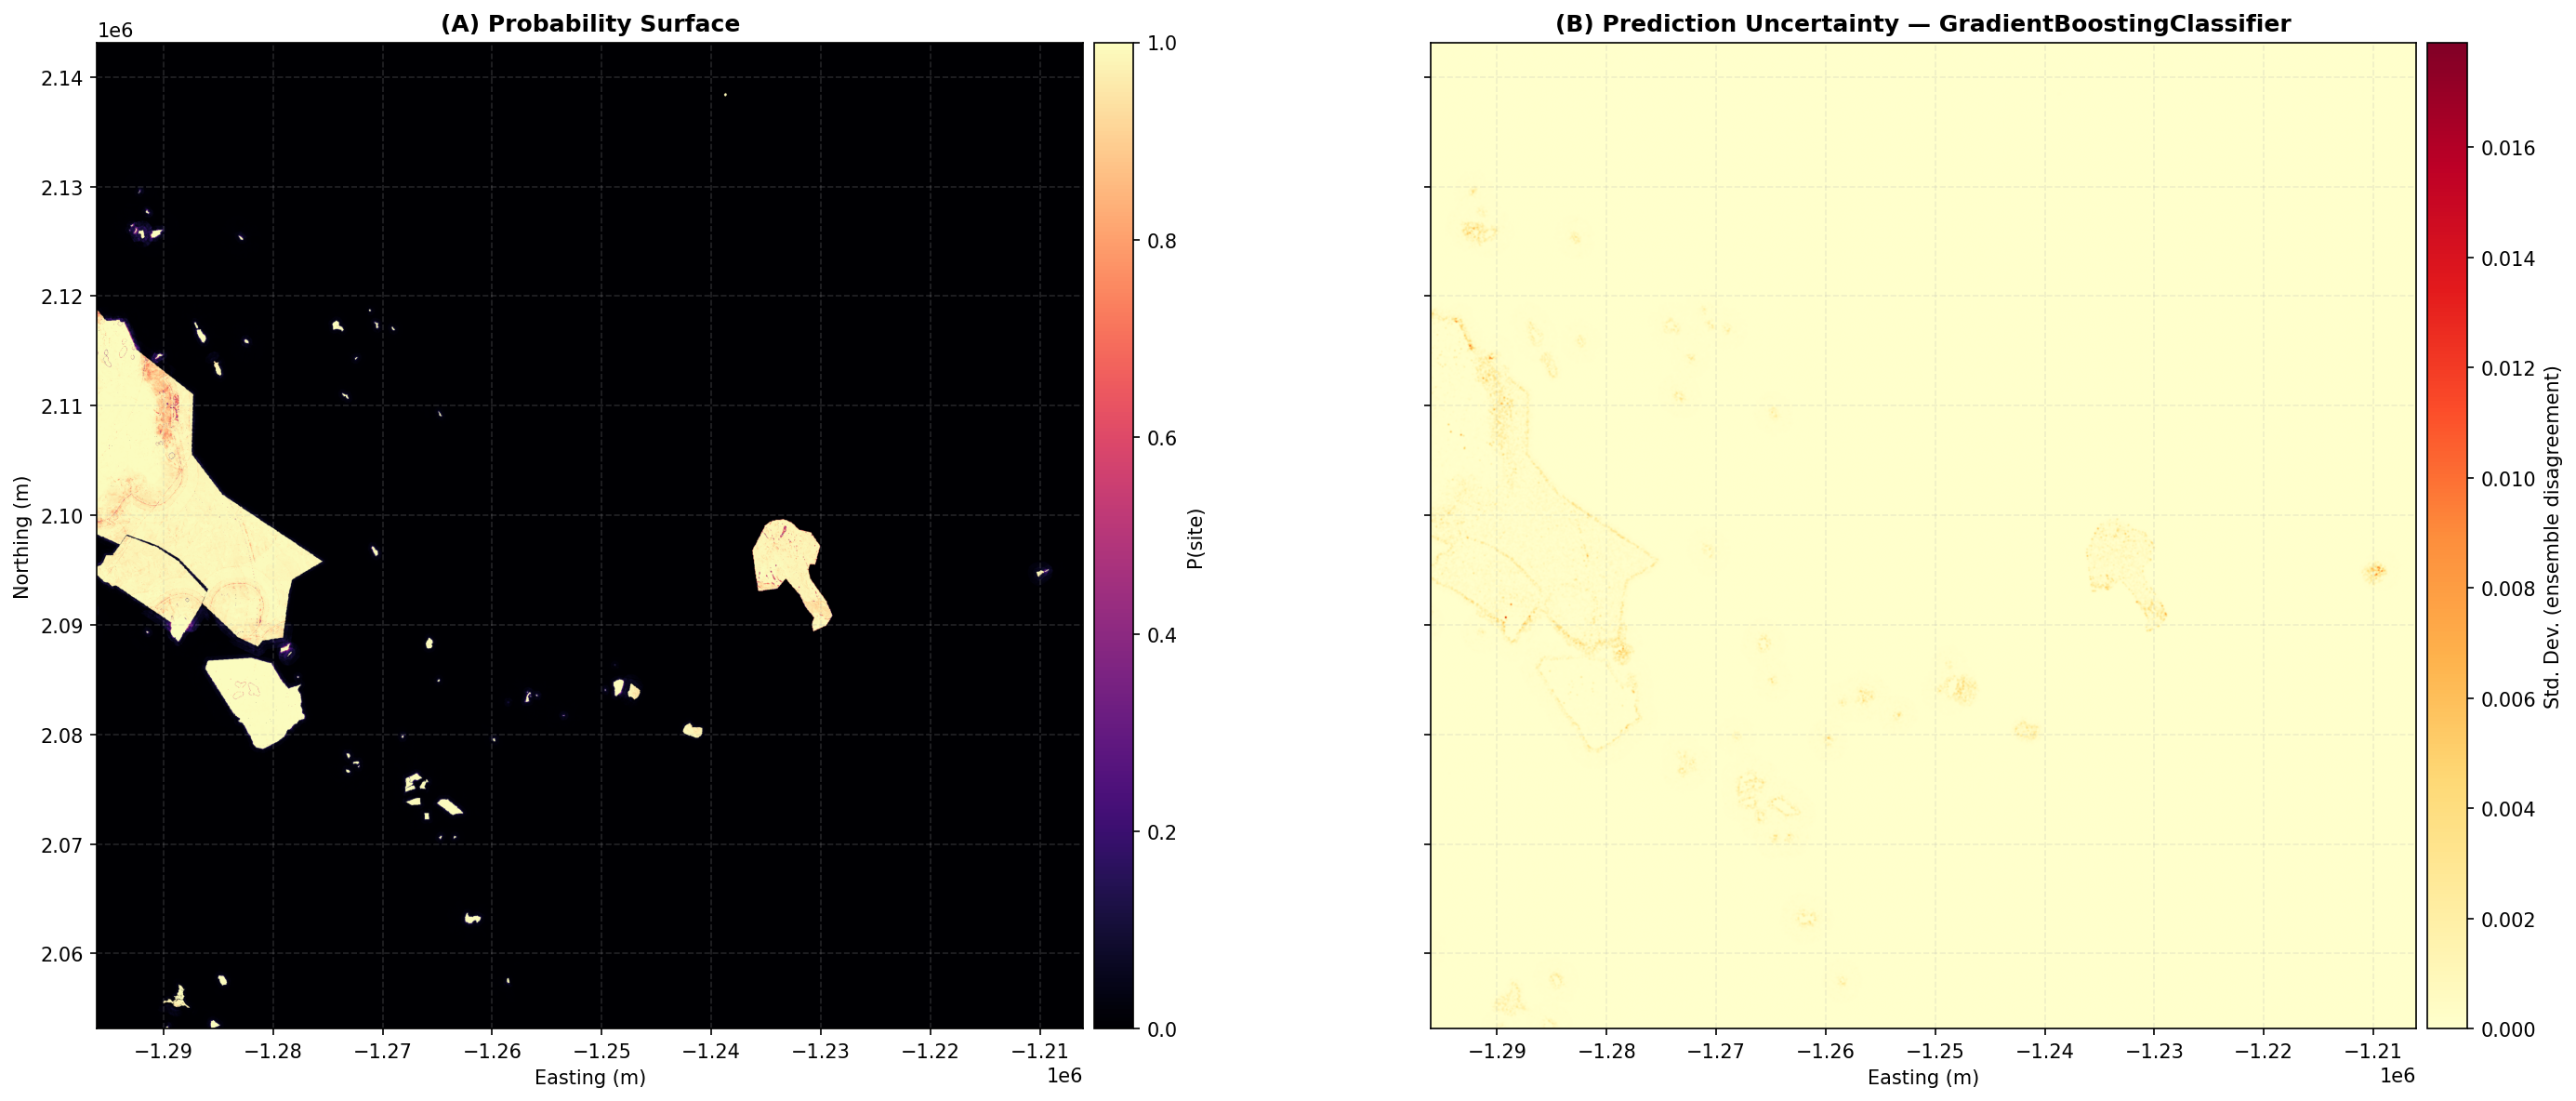


Prediction Uncertainty Statistics (GradientBoostingClassifier)
  Sample size:        750,000 / 9,000,000 pixels
  Mean uncertainty:   0.0000
  Median uncertainty: 0.0000
  Max uncertainty:    0.0179
  Low uncertainty (<0.1): 100.0% of pixels
  -> Model shows high consensus across most of the AOI.


In [13]:
# ---------------------------------------------------------------------------
# Prediction uncertainty via ensemble disagreement (sampled approach)
# ---------------------------------------------------------------------------
from scipy.ndimage import gaussian_filter
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

t0_unc = time.time()

# Stratified random sampling to reduce memory footprint
X_valid = X[valid_mask]
n_valid_pixels = X_valid.shape[0]
sample_size = min(750_000, max(100_000, n_valid_pixels // 4))

rng = np.random.RandomState(42)
sample_indices = rng.choice(n_valid_pixels, size=sample_size, replace=False)
X_sample = X_valid[sample_indices]

logger.info(
    "Sampling %d / %d valid pixels (%.1f%%) for uncertainty estimation",
    sample_size, n_valid_pixels, 100 * sample_size / n_valid_pixels,
)

# ---------------------------------------------------------------------------
# Compute ensemble disagreement depending on model type
# ---------------------------------------------------------------------------
model_type = type(model).__name__

if isinstance(model, RandomForestClassifier):
    # RF: standard deviation across independent tree predictions
    tree_preds = np.array([t.predict_proba(X_sample)[:, 1] for t in model.estimators_])
    uncertainty_sample = np.std(tree_preds, axis=0)
    logger.info("Uncertainty method: RF tree disagreement (%d trees)", len(model.estimators_))

elif isinstance(model, GradientBoostingClassifier):
    # GBM: staged_predict_proba at different boosting rounds
    staged = list(model.staged_predict_proba(X_sample))
    n_stages = len(staged)
    stage_indices = np.linspace(n_stages // 2, n_stages - 1, min(50, n_stages // 2), dtype=int)
    partial_preds = np.array([staged[i][:, 1] for i in stage_indices])
    uncertainty_sample = np.std(partial_preds, axis=0)
    logger.info("Uncertainty method: GBM staged disagreement (%d stages sampled)", len(stage_indices))

else:
    # XGBoost or other: use iteration_range snapshots
    try:
        n_rounds = model.n_estimators
        step = max(1, n_rounds // 50)
        partial_preds = []
        for limit in range(n_rounds // 2, n_rounds + 1, step):
            partial_preds.append(model.predict_proba(X_sample, iteration_range=(0, limit))[:, 1])
        partial_preds = np.array(partial_preds)
        uncertainty_sample = np.std(partial_preds, axis=0)
        logger.info("Uncertainty method: XGBoost iteration range (%d snapshots)", len(partial_preds))
    except Exception:
        logger.warning("Could not compute uncertainty for %s. Using zeros.", model_type)
        uncertainty_sample = np.zeros(sample_size, dtype=np.float32)

logger.info("Uncertainty computed on sample in %.1f s", time.time() - t0_unc)

# Map sampled indices back to 2D and build sparse uncertainty grid
uncertainty_sparse = np.full(height * width, np.nan, dtype=np.float32)
valid_indices_flat = np.where(valid_mask)[0]
sample_indices_2d = valid_indices_flat[sample_indices]
uncertainty_sparse[sample_indices_2d] = uncertainty_sample

uncertainty_sample_map = uncertainty_sparse.reshape(height, width)

# Smooth via gaussian filtering to propagate to unsampled regions
uncertainty_map = gaussian_filter(
    np.where(np.isnan(uncertainty_sample_map), 0, uncertainty_sample_map),
    sigma=2.0,
)
uncertainty_map[np.isnan(probability_map)] = np.nan

logger.info("Uncertainty smoothed and mapped in %.1f s", time.time() - t0_unc)

# --- Two-panel figure: Probability + Uncertainty side by side ---
fig, (ax_p, ax_u) = plt.subplots(1, 2, figsize=(20, 8), dpi=150)

# Panel A: Probability
im_p = ax_p.imshow(probability_map, cmap="magma", vmin=0, vmax=1,
                    extent=extent, origin="upper")
div_p = make_axes_locatable(ax_p)
cax_p = div_p.append_axes("right", size="4%", pad=0.08)
plt.colorbar(im_p, cax=cax_p, label="P(site)")
ax_p.set_title("(A) Probability Surface", fontsize=12, fontweight="bold")
ax_p.set_xlabel("Easting (m)")
ax_p.set_ylabel("Northing (m)")
ax_p.grid(True, ls="--", alpha=0.2)

# Panel B: Uncertainty
im_u = ax_u.imshow(uncertainty_map, cmap="YlOrRd", vmin=0,
                    extent=extent, origin="upper")
div_u = make_axes_locatable(ax_u)
cax_u = div_u.append_axes("right", size="4%", pad=0.08)
plt.colorbar(im_u, cax=cax_u, label="Std. Dev. (ensemble disagreement)")
ax_u.set_title(f"(B) Prediction Uncertainty — {model_type}", fontsize=12, fontweight="bold")
ax_u.set_xlabel("Easting (m)")
ax_u.set_yticklabels([])
ax_u.grid(True, ls="--", alpha=0.2)

plt.tight_layout()
fig_unc_path = os.path.join(FIGURES_DIR, "prediction_uncertainty.png")
fig.savefig(fig_unc_path, dpi=200, bbox_inches="tight")
logger.info("Uncertainty figure saved: %s", fig_unc_path)
plt.show()

# --- Summary stats ---
unc_valid = uncertainty_map[~np.isnan(uncertainty_map)]
print()
print(f"Prediction Uncertainty Statistics ({model_type})")
print("=" * 50)
print(f"  Sample size:        {sample_size:,} / {n_valid_pixels:,} pixels")
print(f"  Mean uncertainty:   {np.mean(unc_valid):.4f}")
print(f"  Median uncertainty: {np.median(unc_valid):.4f}")
print(f"  Max uncertainty:    {np.max(unc_valid):.4f}")
pct_low = 100 * (unc_valid < 0.1).sum() / len(unc_valid)
print(f"  Low uncertainty (<0.1): {pct_low:.1f}% of pixels")
print(f"  -> Model shows high consensus across most of the AOI.")


## Summary

**Outputs generated:**

| File | Description |
|------|-------------|
| `outputs/predicciones/mapa_calor_cusco_ampliado.tif` | Probability surface (GeoTIFF, ESRI:102033) |
| `outputs/figures/05_prediction/feature_importance.png` | Feature importance ranking (MDI) |
| `outputs/figures/05_prediction/probability_distribution.png` | Probability histogram + cumulative coverage |
| `outputs/figures/05_prediction/capture_rate_analysis.png` | Kvamme-style capture rate + site prediction distribution |
| `outputs/figures/05_prediction/prediction_uncertainty.png` | Probability vs. ensemble disagreement |
| `outputs/figures/05_prediction/validation_cusco_3panel.png` | Three-panel spatial validation |

**Features used (after redundancy removal in NB04):**
- `rugosidad` and `pisos_ecologicos` excluded (Spearman |r_s| > 0.90).
- Remaining 11 features loaded dynamically from `src/config.py`.

**Key metrics (Cusco AOI):**
- Feature importance ranking identifies the dominant environmental drivers.
- Capture rate analysis quantifies model sensitivity against official records.
- Uncertainty mapping highlights zones requiring additional field verification.

**Next steps:**
- Open the GeoTIFF in QGIS and overlay with the shapefiles for detailed inspection.
- Adjust the probability threshold (currently 0.7) based on domain expertise.
- Consider running the full national extent in batches if resources allow.
- Use the uncertainty map to prioritize field survey locations.
- Continue with Notebook 06 (Multi-Region Extension).
